In [1]:
# Import the necessary packages to perform the data analysis

# packages to process and visualize the data
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

# import othe useful packages
import os

# packages to improve visual description and analysis
from IPython.core.display import display
pd.set_option('display.max_columns', 100)

In [2]:
# Getting file names

DATA_FOLDER = './data/'

# Panama papers data
edges_csv = 'panama_papers.edges.csv'
intermediary_csv = 'panama_papers.nodes.intermediary.csv' # company or individuals
address_csv = 'panama_papers.nodes.address.csv'
officer_csv = 'panama_papers.nodes.officer.csv'
entity_csv = 'panama_papers.nodes.entity.csv' # tax heaven companies

# forbes data
forbes_csv = 'Forbes2015.csv'

In [3]:
# Importing the data into DataFrames

edges = pd.read_csv(DATA_FOLDER + edges_csv) # mixed columns
intermediary = pd.read_csv(DATA_FOLDER + intermediary_csv)
address = pd.read_csv(DATA_FOLDER + address_csv)
officer = pd.read_csv(DATA_FOLDER + officer_csv)
entity = pd.read_csv(DATA_FOLDER + entity_csv) # mixed columns

# forbes
forbes_2000 = pd.read_csv(DATA_FOLDER + forbes_csv)

/home/eddie/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/eddie/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Handling data size

First we will answer the question of whether we can handle the data in size.

In [4]:
# Printing shapes of each DataFrame to see if any are too large

print("Edges shape: ", edges.shape)
print("Intermediary shape: ", intermediary.shape)
print("Address shape: ", address.shape)
print("Officer shape: ", officer.shape)
print("Entity shape: ", entity.shape)

print("Forbes_2000 shape: ", forbes_2000.shape)

Edges shape:  (674102, 8)
Intermediary shape:  (14110, 8)
Address shape:  (93454, 8)
Officer shape:  (238402, 7)
Entity shape:  (213634, 17)
Forbes_2000 shape:  (2000, 11)


From above, we see that the DataFrame with the most number of rows is around 670,000 rows of data. In total the size of the Panama Papers dataset is around 352 MB, which is small enough for Jupyter Notebook and Pandas to handle effectively. Thus the data can definitely be handled within our approach of using purely a notebook. 

## Understanding the data

Next we understand the data. Although the dataset is downloaded within `csv` format, the data is curated to work well within a graph database (specifically Neo4j as mentioned on the Panama Papers website). Here, the `Edges` table represents the edge connections within a graph database whereas all the other tables (`Intermediary`, `Address`, etc) are nodes within the graph. For example:

In [5]:
display(edges.head(1))

,START_ID,TYPE,END_ID,link,start_date,end_date,sourceID,valid_until
0,10000035,registered_address,14095990,registered address,NaN,NaN,Panama Papers,NaN


To interpret this row in the `Edges` table, the `START_ID` and `END_ID` represent the node ids that the edge is connected to. But the node ids can correspond to any of `Intermediary, Address, Officer, Entity`, which may prove to be difficult in SQL or Pandas merging as we will have to look up the node id in every other table. One solution would be to use Neo4j and the Cypher querying language, which can be used to easily interpret the above information. Below we can see clearly that the start node is an Entity named *CARPENTER NELSON & CO., LTD* and the end node is an Address named *EUROFIN SERVICES S.A. P.O.BOX  6003 LAUSANNE 1002, VAUD SWITZERLAND* and the relationship type is *registered address*.

<img src="ex_query1.png" height="400" width="1000">

For the purposes of our project, we may not even need to use Neo4j to answer our queries. However we have done the above analyis to identify the format of our data, which is crucial because if we do require a certain query, we understand how we can leverage different tools to achieve our goals.

## Data Cleaning

We see that `Edges` Dataframe and `Entity` Dataframe have mixed datatypes in their columns so we will inspect those more clearly. 

In [6]:
start_dates = edges.start_date.unique()[1:]
start_dates = sorted(list(map(lambda x: int(x[-4:]), start_dates)), reverse=True)
print(start_dates[:20])
print(start_dates[-50:])

[2500, 2205, 2201, 2099, 2088, 2088, 2020, 2019, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015]
[1974, 1973, 1973, 1972, 1968, 1966, 1965, 1959, 1957, 1957, 1194, 214, 213, 213, 206, 203, 202, 201, 201, 201, 200, 200, 200, 200, 200, 200, 200, 200, 199, 199, 96, 95, 82, 15, 14, 12, 12, 12, 12, 12, 12, 12, 12, 11, 9, 9, 6, 6, 4, 3]


We first see that the start_date and end_date columns in `Edges` have dates that are nonsensical, such as years that are well before/after 2015. Upon consideration of our research questions, we decide to drop the date columns from `Edges` as well as the Note column in `Entity` (For our research question of timeline of leaked papers, we will need to use the `Entity['incorporation_date']` column).

In [7]:
edges = edges.drop(columns=['start_date', 'end_date'])
entity = entity.drop(columns=['note'])

Furthermore, we see that the `Entity['incorporation_date']` column have acceptable ranges below so we will convert that column from type object to date.

In [8]:
print(entity['incorporation_date'].sort_values().unique())
entity.incorporation_date = pd.to_datetime(entity.incorporation_date)

['01-APR-1975' '01-APR-1977' '01-APR-1981' ... '31-OCT-2013' '31-OCT-2014'
 nan]


Lastly, we will add country codes in the `Forbes` dataset so that countries can be easily matched between that dataset with the Panana papers data. 

In [9]:
import pycountry
forbes_2000.loc[forbes_2000.Country == "Russia", 'Country'] = "Russian Federation"
forbes_2000.loc[forbes_2000.Country == "South Korea", 'Country'] = 'Korea, Republic of'
forbes_2000['Country Code'] = forbes_2000.apply(lambda row: pycountry.countries.lookup(row['Country']).alpha_3, axis=1)

# Sociological Research

**1)** Map the tax heavens jurisdiction in terms of the number of entities they have registered 

**2)** Map countries in the world according to how much they appear in the Panama Papers in terms of the entities

**3)** Explore the GINI coefficient which is a measure of inequality: what is the correlation between counts and gini?

**4)** Explore the HDI coefficient which is a measure of development: what is the correlation between counts and HDI?

**5)** Explore the indices of informal sector, organized crime coefficient which is a measure of inequality: what is the correlation between counts and these indicators?

# Economical Research

**1)** Find how many companies in Fortune 2000 are involved in Panama Papers, present the top rank in the result. NOT FEASIBLE

**2)** Timeline of number of leaked papers over the years (graph). Try to extrapolate a tendecy in this phenomena.

**3)** Amount of lost capital for a country due to tax evasion.


To answer the second question, we will look at the incorporation dates of different entities and groupby count by year to plot a time series chart.

In [17]:
entity['Year'] = entity.apply(lambda row: row['incorporation_date'].year, axis=1)

In [24]:
series = entity.groupby(['Year'], axis=0)['Year'].count()

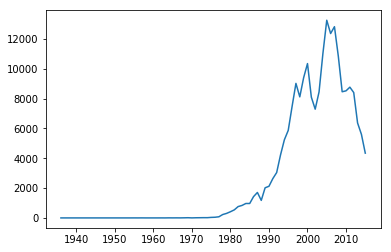

In [30]:
x = series.index.tolist()
y = series.tolist()

plt.plot(x,y)
plt.show()

Thus we observe that the number of incorporations peaked between 20